In [1]:
from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

In [2]:
import os.path
from itertools import chain, combinations
from typing import Dict, List, Tuple, Iterable, Any

import numpy as np
import pandas as pd
from gapstatistics.gapstatistics import GapStatistics
from clustering import AgglomerativeClusteringWrapper as AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy.spatial.distance import jensenshannon, correlation, euclidean
from tqdm.contrib.concurrent import thread_map
import seaborn as sns

import config

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [4]:
from scipy.spatial.distance import correlation

In [5]:
df_explainable: pd.DataFrame = ClusteringApplier.read_explaining_features()
df_observable_distances: pd.DataFrame = pd.read_excel(
    f"{config.OUTPUT_FOLDER_BASE}observables/{config.DATASET_NAME}-distance-normalized-matrix-{config.DISTANCE_MEASURE_FINGERPRINT}-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx",
    index_col=0
)
features: List[str] = list(config.EXPLAINING_FEATURE_NAMES.keys())

# Ensure that both datasets contain the same indices
valid_indices = np.intersect1d(df_explainable.index, df_observable_distances.index)
df_explainable = df_explainable.loc[valid_indices]
df_observable_distances = df_observable_distances.loc[valid_indices]

In [6]:
@torch.jit.script
def torch_correlation(u:torch.Tensor, v:torch.Tensor, w:torch.Tensor|None=None, centered:bool=False) -> torch.Tensor:

    ######################################################################################
    ### Conversion of the correlation distance from scipy.spatial.distance to pytorch. ###
    ######################################################################################

    """
    Compute the correlation distance between two 1-D arrays.

    The correlation distance between `u` and `v`, is
    defined as

    .. math::

        1 - \\frac{(u - \\bar{u}) \\cdot (v - \\bar{v})}
                  {{\\|(u - \\bar{u})\\|}_2 {\\|(v - \\bar{v})\\|}_2}

    where :math:`\\bar{u}` is the mean of the elements of `u`
    and :math:`x \\cdot y` is the dot product of :math:`x` and :math:`y`.

    Parameters
    ----------
    u : (N,) array_like
        Input array.
    v : (N,) array_like
        Input array.
    w : (N,) array_like, optional
        The weights for each value in `u` and `v`. Default is None,
        which gives each value a weight of 1.0
    centered : bool, optional
        If True, `u` and `v` will be centered. Default is True.

    Returns
    -------
    correlation : double
        The correlation distance between 1-D array `u` and `v`.

    Examples
    --------
    Find the correlation between two arrays.

    >>> from scipy.spatial.distance import correlation
    >>> correlation([1, 0, 1], [1, 1, 0])
    1.5

    Using a weighting array, the correlation can be calculated as:

    >>> correlation([1, 0, 1], [1, 1, 0], w=[0.9, 0.1, 0.1])
    1.1

    If centering is not needed, the correlation can be calculated as:

    >>> correlation([1, 0, 1], [1, 1, 0], centered=False)
    0.5
    """

    if w is not None:
        w = w
        w = w / w.sum()
    if centered:
        if w is not None:
            umu = torch.dot(u, w)
            vmu = torch.dot(v, w)
        else:
            umu = torch.mean(u)
            vmu = torch.mean(v)
        u = u - umu
        v = v - vmu
    if w is not None:
        vw = v * w
        uw = u * w
    else:
        vw, uw = v, u
    uv = torch.dot(u, vw)
    uu = torch.dot(u, uw)
    vv = torch.dot(v, vw)
    dist = 1.0 - uv / torch.sqrt(uu * vv)
    # Clip the result to avoid rounding error
    return torch.clip(dist, 0.0, 2.0)

@torch.jit.script
def pearson_corrcoef(x:torch.Tensor, y:torch.Tensor) -> torch.Tensor:
    '''
    Calculates the Person correlation coefficient.
    PyTorch equivalent to numpy.corrcoef(x, y)[0, 1].
    '''

    vx = x - torch.mean(x)
    vy = y - torch.mean(y)
    return torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))

@torch.jit.script
def relative_entropy(p, q):
    return torch.special.entr(q) - torch.special.entr(p)

@torch.jit.script
def torch_jensenshannon(p:torch.Tensor, q:torch.Tensor):

    ########################################################################################
    ### Conversion of the jensenshannon distance from scipy.spatial.distance to pytorch. ###
    ########################################################################################

    """
    Compute the Jensen-Shannon distance (metric) between
    two probability arrays. This is the square root
    of the Jensen-Shannon divergence.

    The Jensen-Shannon distance between two probability
    vectors `p` and `q` is defined as,

    .. math::

       \\sqrt{\\frac{D(p \\parallel m) + D(q \\parallel m)}{2}}

    where :math:`m` is the pointwise mean of :math:`p` and :math:`q`
    and :math:`D` is the Kullback-Leibler divergence.

    This routine will normalize `p` and `q` if they don't sum to 1.0.

    Parameters
    ----------
    p : (N,) array_like
        left probability vector
    q : (N,) array_like
        right probability vector
    base : double, optional
        the base of the logarithm used to compute the output
        if not given, then the routine uses the default base of
        scipy.stats.entropy.
    axis : int, optional
        Axis along which the Jensen-Shannon distances are computed. The default
        is 0.

        .. versionadded:: 1.7.0
    keepdims : bool, optional
        If this is set to `True`, the reduced axes are left in the
        result as dimensions with size one. With this option,
        the result will broadcast correctly against the input array.
        Default is False.

        .. versionadded:: 1.7.0

    Returns
    -------
    js : double or ndarray
        The Jensen-Shannon distances between `p` and `q` along the `axis`.

    Notes
    -----

    .. versionadded:: 1.2.0

    Examples
    --------
    >>> from scipy.spatial import distance
    >>> import numpy as np
    >>> distance.jensenshannon([1.0, 0.0, 0.0], [0.0, 1.0, 0.0], 2.0)
    1.0
    >>> distance.jensenshannon([1.0, 0.0], [0.5, 0.5])
    0.46450140402245893
    >>> distance.jensenshannon([1.0, 0.0, 0.0], [1.0, 0.0, 0.0])
    0.0
    >>> a = np.array([[1, 2, 3, 4],
    ...               [5, 6, 7, 8],
    ...               [9, 10, 11, 12]])
    >>> b = np.array([[13, 14, 15, 16],
    ...               [17, 18, 19, 20],
    ...               [21, 22, 23, 24]])
    >>> distance.jensenshannon(a, b, axis=0)
    array([0.1954288, 0.1447697, 0.1138377, 0.0927636])
    >>> distance.jensenshannon(a, b, axis=1)
    array([0.1402339, 0.0399106, 0.0201815])

    """

    p = p / torch.sum(p, dim=0)
    q = q / torch.sum(q, dim=0)
    
    m = (p + q) / 2.0
    left = relative_entropy(p, m)
    right = relative_entropy(q, m)
    left_sum = torch.sum(left, dim=0)
    right_sum = torch.sum(right, dim=0)
    js = left_sum + right_sum

    return torch.sqrt(js / 2.0)

In [7]:
import torch
from torch.distributions import kl_divergence
from torch.distributions.beta import Beta
from ParameterizedModel.parameterized_model import Paremeterized_Model
from ParameterizedModel.utils.distribution_helpers import mean_std_to_beta_params

@torch.jit.script
def _construct_distance_matrix(A:torch.Tensor, feature_weights:torch.Tensor, range:torch.Tensor) -> torch.Tensor:
    distance_matrix =  torch.stack([
        torch.stack([
            torch_correlation(u = A[i], v = A[j], w = feature_weights)
            for j in range]) for i in range
    ])
    return distance_matrix / distance_matrix.sum()

class FeatureSelectionModel(Paremeterized_Model):
    def __init__(self, df_explainable:pd.DataFrame, df_observable_distances:pd.DataFrame, num_samples:int=1, device='cpu', dtype=torch.float64):
        super().__init__(device, dtype)

        self.tensor_explainable = torch.tensor(df_explainable.to_numpy(), dtype=self.dtype, device=self.device)
        self.tensor_observable_distances = torch.tensor(df_observable_distances.to_numpy(), dtype=self.dtype, device=self.device)

        self.N = self.tensor_explainable.shape[0]
        self.M = len(features)
        self._range = torch.arange(self.N)

        self.feature_names = list(df_explainable.columns)
        self.num_samples = num_samples
        
        alpha, beta = mean_std_to_beta_params(0.5, 0.05)
        alpha_prior, beta_prior = mean_std_to_beta_params(0.001, 0.001)

        noise_1 = torch.rand(len(features))
        noise_2 = torch.rand(len(features))

        alpha_init = alpha * torch.ones(len(features)) * 0.9 + noise_1 * 0.1
        beta_init  = beta  * torch.ones(len(features)) * 0.9 + noise_2 * 0.1

        self.add_param('alpha', torch.log(alpha_init), lambda x: x.exp())
        self.add_param('beta',  torch.log(beta_init), lambda x: x.exp())

        self.Beta_prior = Beta(
            alpha_prior * torch.ones(len(features), dtype = self.dtype, device = self.device),
            beta_prior  * torch.ones(len(features), dtype = self.dtype, device = self.device))
        
        self.best_loss = None 
        self.best_weights = None
        
    def get_feature_weights(self) -> dict:
        #w = Beta(self.constrained('alpha'), self.constrained('beta')).mean.clone().detach().numpy()
        w = self.best_feature_weights
        feature_dict = {feature_name:float(weight) for feature_name, weight in zip(self.feature_names, w)}
        return feature_dict
    
    def get_feature_certainty(self) -> dict:
        s = Beta(self.constrained('alpha'), self.constrained('beta')).stddev.clone().detach().numpy()
        stdev_dict = {feature_name:float(std) for feature_name, std in zip(self.feature_names, s)}
        return stdev_dict
    
    def save_if_best_loss(self, loss, feature_weights):
        if self.best_loss is None:
            self.best_loss = loss.clone().detach()
            self.best_feature_weights = feature_weights.clone().detach()
        elif loss < self.best_loss:
            self.best_loss = loss.clone().detach()
            self.best_feature_weights = feature_weights.clone().detach()

    def sample(self, num_samples:int=1000):
        samples = Beta(self.constrained('alpha'), self.constrained('beta')).sample([num_samples]).numpy()
        res_df = pd.DataFrame({self.feature_names[i]:samples[:, i] for i in range(len(self.feature_names))})
        return res_df
    
    def plot(self, num_samples:int=1000):
        plt.figure(figsize=(10, 5))
        sns.barplot(self.sample(num_samples))

    def loss(self, data:torch.Tensor|None=None) -> torch.tensor:
 
        # Sample feature_weights
        feature_weights = Beta(self.constrained('alpha'), self.constrained('beta')).rsample([self.num_samples]).mean(dim = 0)
        #prior_weights = self.Beta_prior.mean #sample([self.num_samples]).mean
      
        # Construct the distance_matrix 
        distance_matrix = _construct_distance_matrix(A=self.tensor_explainable, feature_weights=feature_weights, range=self._range)

        # Calculate the correlation between the distance matrix and the observable distances
        coef = pearson_corrcoef(distance_matrix, self.tensor_observable_distances)

        # Distance to the Prior
        #dist = torch_jensenshannon(feature_weights, prior_weights) / self.N
        #eucl_dist = (feature_weights - prior_weights).pow(2).sum().sqrt()
        #dist = eucl_dist / self.N

        # Loss
        loss = -coef #+ dist

        self.save_if_best_loss(loss, feature_weights)

        return loss


In [8]:
from ParameterizedModel.training import Trainer

In [9]:
model = FeatureSelectionModel(df_explainable, df_observable_distances, num_samples=1)

# After this many steps, the learning rate is halved
HALFLIFE = 65

optimizer = torch.optim.RMSprop(
    params = [
        {'params': model.parameters['alpha'], 'lr': 0.1, 'momentum': 0.5},
        {'params': model.parameters['beta'],  'lr': 0.1, 'momentum': 0.5},
    ]
)

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)

In [10]:
trainer = Trainer(model = model, optimizer = optimizer, scheduler = scheduler, dataloader = range(10))

In [11]:
trainer.train(epochs = 300, timeout=60000)

1/300 --- Mean Loss : -0.1732224697997422
2/300 --- Mean Loss : -0.19337548031697627
3/300 --- Mean Loss : -0.1974797499464454
4/300 --- Mean Loss : -0.24459040793267028
5/300 --- Mean Loss : -0.2583075858325248
6/300 --- Mean Loss : -0.25863455241860883
7/300 --- Mean Loss : -0.257970734461868
8/300 --- Mean Loss : -0.2649561033973401
9/300 --- Mean Loss : -0.2573249856931855
10/300 --- Mean Loss : -0.2632235701892664
11/300 --- Mean Loss : -0.2625631839503193
12/300 --- Mean Loss : -0.2661854253674525
13/300 --- Mean Loss : -0.2606973390221903
14/300 --- Mean Loss : -0.2617787519953314
15/300 --- Mean Loss : -0.26285700660336997
16/300 --- Mean Loss : -0.2640077337197846
17/300 --- Mean Loss : -0.26435426890588304
18/300 --- Mean Loss : -0.26666061805031094
19/300 --- Mean Loss : -0.2655596879349481
20/300 --- Mean Loss : -0.26573296170608024
21/300 --- Mean Loss : -0.266598764374786
22/300 --- Mean Loss : -0.26357223402906177
23/300 --- Mean Loss : -0.26623798787690733
24/300 --- Me

In [12]:
float(model.best_loss)

-0.2698136823712533

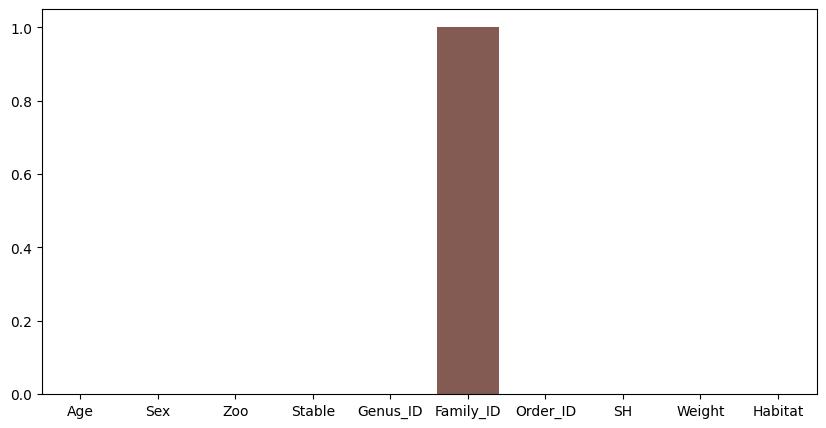

In [13]:
model.plot()

In [13]:
...

Ellipsis